# HW1 -- First PolyBench/C GEMM optimization

### Background

This report covers changes made to the GEMM kernel in PolyBench/C 4.2.1-beta, a benchmarking suite built by Louis-Noel Pouchet and Tomofumi Yuki. PolyBench/C is copyright of The Ohio State University and can be found on Sourceforge [here](https://sourceforge.net/projects/polybench/).

This experiment is being performed on lab machine `pollock`, an Intel i7-12700K 12-core 20-thread system. The version of `gcc` available on this machine is 8.5.0 by default. `clang` 16.0.6 is also available, and generally produces better performing results, but is not used here due to familiarity and to make this report compatible with others' work.

In [1]:
import os

In [2]:
! lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              20
On-line CPU(s) list: 0-19
Thread(s) per core:  1
Core(s) per socket:  12
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               151
Model name:          12th Gen Intel(R) Core(TM) i7-12700K
Stepping:            2
CPU MHz:             3600.000
CPU max MHz:         5000.0000
CPU min MHz:         800.0000
BogoMIPS:            7219.20
Virtualization:      VT-x
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            25600K
NUMA node0 CPU(s):   0-19
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl vmx s

In [3]:
! gcc -v

Using built-in specs.
COLLECT_GCC=gcc
COLLECT_LTO_WRAPPER=/usr/libexec/gcc/x86_64-redhat-linux/8/lto-wrapper
OFFLOAD_TARGET_NAMES=nvptx-none
OFFLOAD_TARGET_DEFAULT=1
Target: x86_64-redhat-linux
Configured with: ../configure --enable-bootstrap --enable-languages=c,c++,fortran,lto --prefix=/usr --mandir=/usr/share/man --infodir=/usr/share/info --with-bugurl=http://bugs.almalinux.org/ --enable-shared --enable-threads=posix --enable-checking=release --enable-multilib --with-system-zlib --enable-__cxa_atexit --disable-libunwind-exceptions --enable-gnu-unique-object --enable-linker-build-id --with-gcc-major-version-only --with-linker-hash-style=gnu --enable-plugin --enable-initfini-array --with-isl --disable-libmpx --enable-offload-targets=nvptx-none --without-cuda-driver --enable-gnu-indirect-function --enable-cet --with-tune=generic --with-arch_32=x86-64 --build=x86_64-redhat-linux
Thread model: posix
gcc version 8.5.0 20210514 (Red Hat 8.5.0-20) (GCC) 


### Testing Methodology

For this experiment, the following autotuning script was built to test GEMM iterations across various targets. Portions of this script and data returned from these runs will be used throughout this report. PB/C's GEMM is designed to print out a benchmark time of its call to the kernel, i.e. the portion of the script where the matrix multiplication is processed. This output is scraped by this autotuner and saved as a float.

In [2]:
import subprocess
import numpy
import time

def autotune_batcher(binary='my_binary', epoch=20, verbose=True):
    if verbose: print('Running ' + binary + ' for ' + str(epoch) + ' epoch...')
    times = []
    for _ in range(epoch):
        times.append(float(subprocess.run(['./' + binary], stdout=subprocess.PIPE).stdout.decode('utf-8').rstrip()))
    return times

def autotune_builder(optargs=['-O3'], filename='gemm.c', sz=None): # refactor? too GEMM specific for reuse
    command = ['gcc']
    command += optargs
    command += ['-I', 'utilities', '-I', 'linear-algebra/blas/gemm', 'utilities/polybench.c',
                'linear-algebra/blas/gemm/' + filename, '-DPOLYBENCH_TIME']
    if sz is not None:
        command += ['-DNI=' + sz, '-DNJ=' + sz, '-DNK=' + sz, '-o', sz]
    else:
        command += ['-o', 'my_binary']
    subprocess.run(command)
    return command[-1]

def autotune_sizes(szs=['512', '513', '1000', '1024', '2000', '2048'], 
                   filename='gemm.c',
                   epoch=20,
                   optargs=['-O3'],
                   verbose=True):
    results = {}
    for sz in szs:
        if verbose: print('Initializing ' + filename + ' using ' + str(optargs) + ' on size ' + sz)
        results[sz] = autotune_batcher(autotune_builder(optargs=optargs, filename=filename, sz=sz), epoch=epoch, verbose=verbose) 
    return results

def autotune_full(szs=['512', '513', '1000', '1024', '2000', '2048'], 
                  filename='gemm.c',
                  epoch=20,
                  optargss=[['-O0'], ['-O1'], ['-O2'], ['-O3'], ['-O3', '-fno-tree-vectorize'], ['-Ofast']],
                  verbose=False):
    print('Begin full autotune...')
    t = time.time()
    results = {}
    for optargs in optargss:
        results[optargs[-1]] = autotune_sizes(szs=szs, filename=filename, epoch=epoch, optargs=optargs, verbose=verbose)
    t = time.time() - t
    print('Full autotune took ' + str(t) + ' sec.')
    return results

def calc_gflops_gemm_3(fSeconds, iI, iJ, iK):
    iBallpark_ops = (iI*iJ*iK)*3 + iI*iJ # float mul in first loop (n^2), 2x float mul + float add in second loop (n^3)
    fFlops = iBallpark_ops / fSeconds
    return (fFlops/1000000000)

def calc_gflops_gemm(fSeconds, iN):
    return calc_gflops_gemm_3(fSeconds, iN, iN, iN)

def report_builder_single(results):
    gflops = {}
    for k in results.keys():
        iK = int(k)
        avg = numpy.average(results[k])
        print('For size ' + k + ', the average time was ' + str(round(avg,5)) + ' seconds (' + str(round(min(results[k]), 5)) + ' minimum/' + str(round(max(results[k]), 5)) + ' maximum)')
        gflops[k] = calc_gflops_gemm(avg, iK)
    return gflops
        

def report_builder_full(results):
    gflops = {}
    for k in results.keys():
        print('The following times were collected using the ' + k + ' optimization flag:')
        curr_gflops = report_builder_single(results[k])
        for e in curr_gflops.keys():
            if e not in gflops or gflops[e][1] < curr_gflops[e]:
                gflops[e] = (k, curr_gflops[e])
        print()
    for k in gflops.keys():
        print('The best average result for size ' + k + ' was with optimization flag ' + gflops[k][0] + ', demonstrating approximately ' + str(round(gflops[k][1], 3)) + ' GFLOPS.')

### Optimizations

Two optimization attempts on the core were built and tested. For reference, the initial GEMM kernel is the following:

```
#pragma scop
  for (i = 0; i < _PB_NI; i++) {
    for (j = 0; j < _PB_NJ; j++)
	C[i][j] *= beta;
    for (k = 0; k < _PB_NK; k++) {
       for (j = 0; j < _PB_NJ; j++)
	  C[i][j] += alpha * A[i][k] * B[k][j];
    }
  }
#pragma endscop
```

In [5]:
# BASE CODE
times_base = autotune_batcher(binary=autotune_builder(filename='gemm.c'))
avg_base = numpy.average(times_base)
print(str(round(avg_base,5)) + ' sec on average.')
print(str(round(calc_gflops_gemm_3(avg_base, 1000, 1100, 1200),3)) + ' GFLOPS on average.') # large_dataset default see gemm.h

Running my_binary for 20 epoch...
0.24478 sec on average.
16.182 GFLOPS on average.


In [6]:
! gcc -O3 -ftree-vectorize -fopt-info-vec-optimized -I utilities -I linear-algebra/blas/gemm utilities/polybench.c linear-algebra/blas/gemm/gemm.c -DPOLYBENCH_TIME -o my_binary

utilities/polybench.c:121:3: note: loop vectorized
utilities/polybench.c:121:3: note: loop vectorized
utilities/polybench.c:121:3: note: loop vectorized
linear-algebra/blas/gemm/gemm.c:93:8: note: loop vectorized
linear-algebra/blas/gemm/gemm.c:93:8: note: loop versioned for vectorization because of possible aliasing
linear-algebra/blas/gemm/gemm.c:90:5: note: loop vectorized
linear-algebra/blas/gemm/gemm.c:44:5: note: loop vectorized
linear-algebra/blas/gemm/gemm.c:41:5: note: loop vectorized
linear-algebra/blas/gemm/gemm.c:38:5: note: loop vectorized


Overall, my goal with my optimizations was to simplify the loops such that the compiler can more readily analyze the goal of the program. The base code already is in a state where some loop vectorization can take place, namely the two j loops, but the script is fairly complex. In the initial revision of this code, two tasks involving i & j are present.

The first, the C\*beta step, can be moved out of the nested loop. This portion is irrelevant to the triple-nested loop doing the alpha\*A\*B segment of GEMM & none of the second task's goals occur before the first. In the original code, each i row is calculated for C\*beta before alpha\*A\*B; the second iteration simply calculates the entire array before moving on to the second step. While there are now sequential i loops within this code, the benefits demonstrated far outweigh any potential minor costs. For reference, the first revision looped code of the GEMM kernel is the following:
```
#pragma scop
  for (i = 0; i < _PB_NI; i++) {
    for (j = 0; j < _PB_NJ; j++)
    	C[i][j] *= beta;
  }
  for (i = 0; i < _PB_NI; i++) {
    for (k = 0; k < _PB_NK; k++) {
       for (j = 0; j < _PB_NJ; j++)
	  C[i][j] += alpha * A[i][k] * B[k][j];
    }
  }
#pragma endscop
```

In [7]:
# REVISION ONE
times_1 = autotune_batcher(binary=autotune_builder(filename='gemm1.c'))
avg_1 = numpy.average(times_1)
print(str(round(avg_1,5)) + ' sec on average.')
print(str(round(calc_gflops_gemm_3(avg_1, 1000, 1100, 1200),3)) + ' GFLOPS on average.') # large_dataset default see gemm.h

Running my_binary for 20 epoch...
0.18407 sec on average.
21.52 GFLOPS on average.


In [8]:
! gcc -O3 -ftree-vectorize -fopt-info-vec-optimized -I utilities -I linear-algebra/blas/gemm utilities/polybench.c linear-algebra/blas/gemm/gemm1.c -DPOLYBENCH_TIME -o my_binary

utilities/polybench.c:121:3: note: loop vectorized
utilities/polybench.c:121:3: note: loop vectorized
utilities/polybench.c:121:3: note: loop vectorized
linear-algebra/blas/gemm/gemm1.c:95:8: note: loop vectorized
linear-algebra/blas/gemm/gemm1.c:95:8: note: loop versioned for vectorization because of possible aliasing
linear-algebra/blas/gemm/gemm1.c:90:5: note: loop vectorized
linear-algebra/blas/gemm/gemm1.c:44:5: note: loop vectorized
linear-algebra/blas/gemm/gemm1.c:41:5: note: loop vectorized
linear-algebra/blas/gemm/gemm1.c:38:5: note: loop vectorized


My second iteration of this code was partial unrolling of our alpha\*A\*B calculation. Unfortunately, my reasoning for *why* this works isn't as sound as I would like it to be, but I made this decision based on the k loop's unvectorized status. Complex access patterns are often ignored by `gcc`. While the second j loop is vectorized, fetches defined from k leave performance on the table. A\[i\]\[k\] will get an entire cache line rather than a single value. I suspected that because B\[k\]\[j\] is non-sequential, `gcc` defaulted to fetching on A again for each iteration of k. I switched to strides of length 4 for the k loop and added an additional loop to handle the remainder. For reference, the second revision looped code of the GEMM kernel is the following: 
```
#pragma scop
  for (i = 0; i < _PB_NI; ++i) {
    for (j = 0; j < _PB_NJ; ++j)
      C[i][j] *= beta;
  }
  int _PB_NK_SF = _PB_NK - _PB_NK % 4;
  for (i = 0; i < _PB_NI; ++i) {
    for (k = 0; k < _PB_NK_SF; k += 4) {
      for (j = 0; j < _PB_NJ; ++j) {
        C[i][j] += alpha * A[i][k] * B[k][j];
        C[i][j] += alpha * A[i][k+1] * B[k+1][j];
        C[i][j] += alpha * A[i][k+2] * B[k+2][j];
        C[i][j] += alpha * A[i][k+3] * B[k+3][j];
      }
    }
  }
  for (i = 0; i < _PB_NI; ++i) {
    for (k = _PB_NK_SF; k < _PB_NK; ++k) {
      for (j = 0; j < _PB_NJ; ++j) {
        C[i][j] += alpha * A[i][k] * B[k][j];
      }
    }
  }
#pragma endscop
```

In [9]:
# REVISION TWO
times_2 = autotune_batcher(binary=autotune_builder(filename='gemm2.c'))
avg_2 = numpy.average(times_2)
print(str(round(avg_2,5)) + ' sec on average.')
print(str(round(calc_gflops_gemm_3(avg_2, 1000, 1100, 1200),3)) + ' GFLOPS on average.') # large_dataset default see gemm.h

Running my_binary for 20 epoch...
0.13903 sec on average.
28.49 GFLOPS on average.


In [10]:
! gcc -O3 -ftree-vectorize -fopt-info-vec-optimized -I utilities -I linear-algebra/blas/gemm utilities/polybench.c linear-algebra/blas/gemm/gemm2.c -DPOLYBENCH_TIME -o my_binary

utilities/polybench.c:121:3: note: loop vectorized
utilities/polybench.c:121:3: note: loop vectorized
utilities/polybench.c:121:3: note: loop vectorized
linear-algebra/blas/gemm/gemm2.c:96:7: note: loop vectorized
linear-algebra/blas/gemm/gemm2.c:96:7: note: loop versioned for vectorization because of possible aliasing
linear-algebra/blas/gemm/gemm2.c:90:5: note: loop vectorized
linear-algebra/blas/gemm/gemm2.c:44:5: note: loop vectorized
linear-algebra/blas/gemm/gemm2.c:41:5: note: loop vectorized
linear-algebra/blas/gemm/gemm2.c:38:5: note: loop vectorized


The following two full autotunes, one for the original version and the second revision of the GEMM core, will be the source of data analyzed in the next sections. The dictionaries will be serialized & their pickles can be loaded to prevent rerunning the script; these will be provided as supplement to this report.  

In [11]:
import pickle
autotunedfull = autotune_full()
autotunedfull2 = autotune_full(filename='gemm2.c')

file = open('gemm.pickle', 'wb')
pickle.dump(autotunedfull, file)
file.close()

file = open('gemm2.pickle', 'wb')
pickle.dump(autotunedfull2, file)
file.close()

Begin full autotune...
Full autotune took 1288.6435747146606 sec.
Begin full autotune...
Full autotune took 1057.1508729457855 sec.


In [1]:
# To reload the data, run this cell.
import pickle

file = open('gemm.pickle', 'rb')
autotunedfull = pickle.load(file)
file.close()

file = open('gemm2.pickle', 'rb')
autotunedfull2 = pickle.load(file)
file.close()

### Autotuning for array sizes

The following analysis will focus the `-O3`-compiled run of the original GEMM program; this data is pulled from the full autotune.

In [3]:
autotuned4 = autotunedfull['-O3']
report_builder_single(autotuned4)
print('Distribution of times and GFLOPS are shown below:')

For size 512, the average time was 0.02049 seconds (0.01932 minimum/0.02284 maximum)
For size 513, the average time was 0.02331 seconds (0.02138 minimum/0.02515 maximum)
For size 1000, the average time was 0.14471 seconds (0.13574 minimum/0.16201 maximum)
For size 1024, the average time was 0.15276 seconds (0.14597 minimum/0.17492 maximum)
For size 2000, the average time was 2.34091 seconds (2.22656 minimum/2.37895 maximum)
For size 2048, the average time was 2.52323 seconds (2.48286 minimum/2.64326 maximum)
Distribution of times and GFLOPS are shown below:


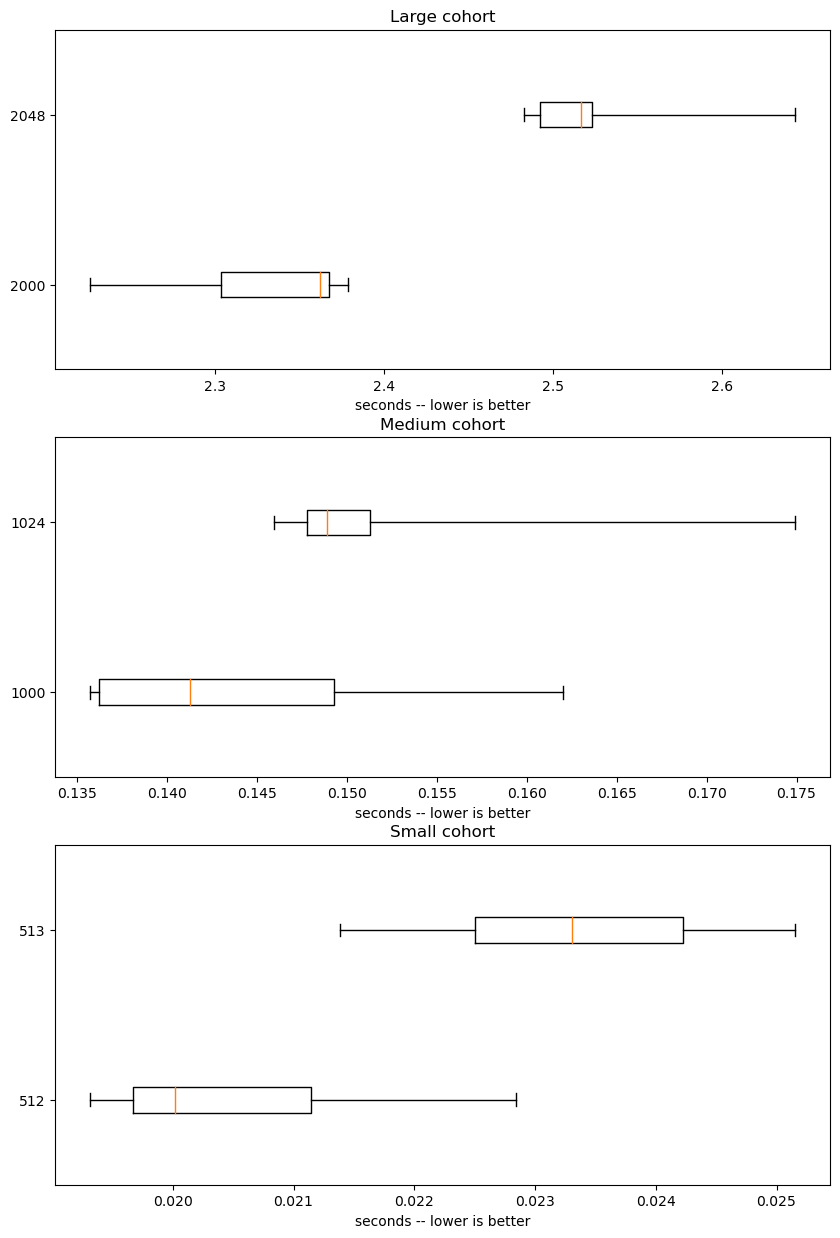

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
figure, axis = plt.subplots(3,1, figsize=(10, 15)) 

axis[0].boxplot(list(autotuned4.values())[4:], vert = 0, whis=50000)
axis[0].set_yticklabels(['2000', '2048'])
axis[0].set_title('Large cohort')
axis[1].boxplot(list(autotuned4.values())[2:4], vert = 0, whis=50000)
axis[1].set_yticklabels(['1000', '1024'])
axis[1].set_title('Medium cohort')
axis[2].boxplot(list(autotuned4.values())[:2], vert = 0, whis=50000)
axis[2].set_yticklabels(['512', '513'])
axis[2].set_title('Small cohort')
for a in axis:
    a.set_xlabel('seconds -- lower is better')

plt.show()

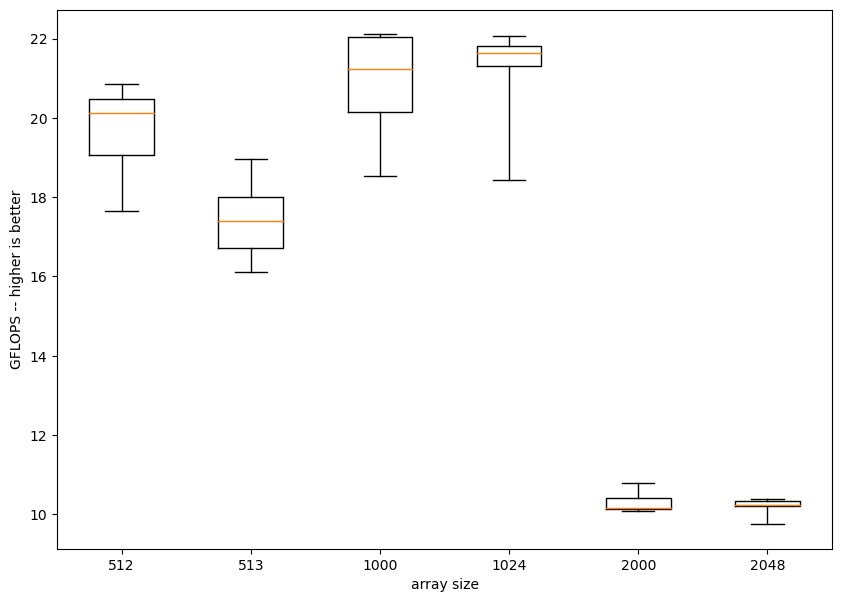

In [5]:
flops_seen = []
for size, results in zip([512, 513, 1000, 1024, 2000, 2048], autotuned4.values()):
    flops_seen.append([calc_gflops_gemm(seconds, size) for seconds in results])
fig = plt.figure(figsize =(10, 7))
plt.boxplot(flops_seen, whis=50000)
plt.xticks([1, 2, 3, 4, 5, 6], ['512', '513', '1000', '1024', '2000', '2048'])
plt.ylabel('GFLOPS -- higher is better')
plt.xlabel('array size')
plt.show()

In [6]:
for size, results in zip(['512', '513', '1000', '1024', '2000', '2048'], flops_seen):
    print('The maximum GFLOPS seen for size ' + size + ' was ' + str(round(max(results),3)) + ' GFLOPS.')

The maximum GFLOPS seen for size 512 was 20.857 GFLOPS.
The maximum GFLOPS seen for size 513 was 18.955 GFLOPS.
The maximum GFLOPS seen for size 1000 was 22.109 GFLOPS.
The maximum GFLOPS seen for size 1024 was 22.075 GFLOPS.
The maximum GFLOPS seen for size 2000 was 10.781 GFLOPS.
The maximum GFLOPS seen for size 2048 was 10.381 GFLOPS.


The time variation across runs for the same value of N can be caused by a number of factors. This program is running on a machine I have limited control over. While I did schedule these tests in the middle of the night, these are machines that can handle multiple users at once. The autotuner may have had lower priority at times for the scheduler; this is particularly relevant for 1024. A small number of 1024 runs were significant outliers and ran at approximately 4 GFLOPS worse than other attempts. Additionally, the processor may have downclocked on some runs due to load. Boost is not disabled on these machines. While it's likely the CPU would be on the higher end of speeds available to it, the frequency could be anywhere from 800 MHz up to 5 GHz. This inconsistency is out of my control and likely leads to most of the variation demonstrated here, beyond the significant outliers.

For me, this variation is less interesting than the relation between various sizes. Immediately, there's a significant drop in performance from 1024 to 2000 size loads. It's likely communication speed significantly slowed these runs, as these batches are larger than the L2 cache size on the 12700K. The dip from 512 to 513 is also interesting, my guess here is that the serial versioned branch of the second j loop is taken at higher indices due to the odd size of j.

As established, on `-O3`, the program is SIMD vectorized for both j loops. 

### Compiler Options Autotune

Below is a report of the full autotune for the orginal version of GEMM. I chose to report the average GFLOPS here as that seems more relevant in an uncontrolled system rather than the absolute highest demonstrated. `-O3` and `-Ofast` use SIMD vectorization for the loops.

In [7]:
report_builder_full(autotunedfull)

The following times were collected using the -O0 optimization flag:
For size 512, the average time was 0.21123 seconds (0.20873 minimum/0.22053 maximum)
For size 513, the average time was 0.26168 seconds (0.26027 minimum/0.26472 maximum)
For size 1000, the average time was 1.49219 seconds (1.48777 minimum/1.50063 maximum)
For size 1024, the average time was 1.65012 seconds (1.64529 minimum/1.65751 maximum)
For size 2000, the average time was 11.95958 seconds (11.8494 minimum/12.27431 maximum)
For size 2048, the average time was 13.23654 seconds (13.18058 minimum/13.28119 maximum)

The following times were collected using the -O1 optimization flag:
For size 512, the average time was 0.05304 seconds (0.04818 minimum/0.05614 maximum)
For size 513, the average time was 0.03921 seconds (0.03659 minimum/0.04861 maximum)
For size 1000, the average time was 0.3373 seconds (0.3162 minimum/0.37099 maximum)
For size 1024, the average time was 0.41156 seconds (0.38404 minimum/0.42994 maximum)
For 

### Alternative Version Autotune

Below is a report of the full autotune for the second iteration of GEMM. The same optimization levels for `gcc` are used here; the same SIMD status applies to each option.

In [8]:
report_builder_full(autotunedfull2)

The following times were collected using the -O0 optimization flag:
For size 512, the average time was 0.20156 seconds (0.2006 minimum/0.20436 maximum)
For size 513, the average time was 0.25413 seconds (0.25294 minimum/0.25588 maximum)
For size 1000, the average time was 1.40226 seconds (1.39964 minimum/1.41139 maximum)
For size 1024, the average time was 1.60152 seconds (1.59969 minimum/1.60607 maximum)
For size 2000, the average time was 11.44771 seconds (11.41683 minimum/11.59127 maximum)
For size 2048, the average time was 13.13609 seconds (13.09668 minimum/13.20725 maximum)

The following times were collected using the -O1 optimization flag:
For size 512, the average time was 0.03681 seconds (0.03424 minimum/0.04455 maximum)
For size 513, the average time was 0.03423 seconds (0.03217 minimum/0.04249 maximum)
For size 1000, the average time was 0.24115 seconds (0.22519 minimum/0.29466 maximum)
For size 1024, the average time was 0.29704 seconds (0.27425 minimum/0.35346 maximum)
Fo